In [1]:
% matplotlib inline
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt

from math import isinf

Visualizing example dataset for outlier detection.


[0, 30, 0, 30]

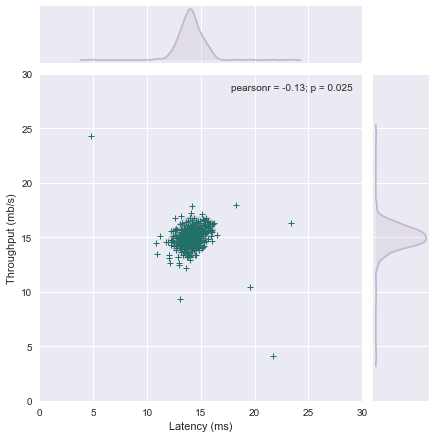

In [66]:
print('Visualizing example dataset for outlier detection.')

#  The following command loads the dataset. You should now have the
#  variables X, Xval, yval in your environment
data = scipy.io.loadmat('ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].flatten()

#  Visualize the example dataset
# plt.plot(X[:, 0], X[:, 1], 'bx')
g = sns.jointplot(x=X[:, 0], y=X[:, 1], data=X, kind="kde", color="#C4B7D0")
g.plot_joint(plt.scatter, c="#207068", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

In [73]:
def multivariateGaussian(X, mu, Sigma2):
    """Computes the probability
    density function of the examples X under the multivariate gaussian
    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
    treated as the covariance matrix. If Sigma2 is a vector, it is treated
    as the \sigma^2 values of the variances in each dimension (a diagonal
    covariance matrix)
    """
    k = len(mu)

    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5) * \
        np.exp(-0.5 * np.sum(X.dot(np.linalg.pinv(Sigma2))*X, axis=1))

    return p

def visualizeFit(X, mu, sigma2):
    """
    This visualization shows you the
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    fig, ax = plt.subplots(figsize=[8,8])
    
    n = np.linspace(0,35,71)
    X1 = np.meshgrid(n,n)
    Z = multivariateGaussian(np.column_stack((X1[0].T.flatten(), X1[1].T.flatten())),mu,sigma2)
    Z = Z.reshape(X1[0].shape)

    ax.plot(X[:, 0], X[:, 1],'bo')
    # Do not plot if there are infinities
    if not isinf(np.sum(Z)):
        ax.contour(X1[0], X1[1], Z, 10.0**np.arange(-20, 0, 3).T)

def estimateGaussian(X):
    """
    This function estimates the parameters of a
    Gaussian distribution using the data in X
      The input X is the dataset with each n-dimensional data point in one row
      The output is an n-dimensional vector mu, the mean of the data set
      and the variances sigma^2, an n x 1 vector
    """
    m = len(X)

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the mean of the data and the variances
    #               In particular, mu(i) should contain the mean of
    #               the data for the i-th feature and sigma2(i)
    #               should contain variance of the i-th feature.
    #
# =============================================================
    mu = []
    sigma2 = []
    for col_num in range(0,X.shape[1]):
        feature_col = X[:, col_num]
        mu.append(feature_col.mean())
        sigma2.append(np.var(feature_col))
    return np.array(mu), np.array(sigma2)

Visualizing Gaussian fit.


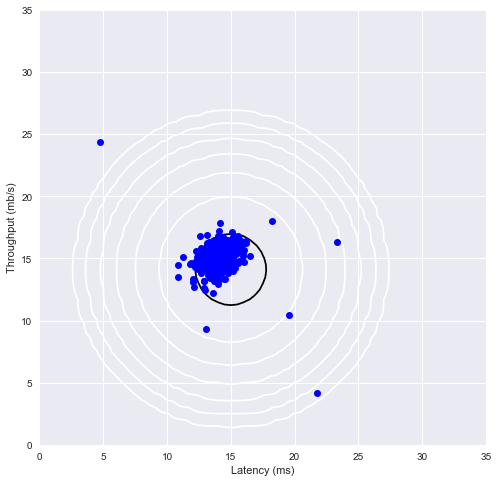

In [88]:
print('Visualizing Gaussian fit.')

#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

In [110]:
from sklearn.metrics import f1_score

def selectThreshold(yval, pval):
    """
    finds the best
    threshold to use for selecting outliers based on the results from a
    validation set (pval) and the ground truth (yval).
    """

    bestEpsilon = 0
    bestF1 = 0

    stepsize = (np.max(pval) - np.min(pval)) / 1000.0
    for epsilon in np.arange(np.min(pval),np.max(pval), stepsize):
        # ====================== YOUR CODE HERE ======================
        # Instructions: Compute the F1 score of choosing epsilon as the
        #               threshold and place the value in F1. The code at the
        #               end of the loop will compare the F1 score for this
        #               choice of epsilon and set it to be the best epsilon if
        #               it is better than the current choice of epsilon.
        #
        # Note: You can use predictions = (pval < epsilon) to get a binary vector
        #       of 0's and 1's of the outlier predictions
        pred = (pval < epsilon).astype('int')
        F1 = f1_score(yval, pred)
        # =============================================================
        if F1 > bestF1:
           bestF1 = F1
           bestEpsilon = epsilon

    return bestEpsilon, bestF1


c:\users\matka\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)


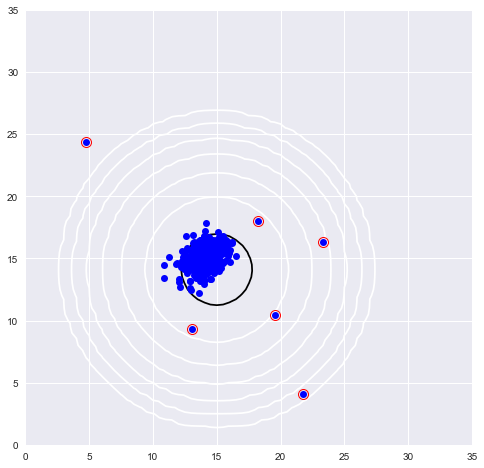

In [111]:

pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')

#  Find the outliers in the training set and plot the
outliers = np.where(p < epsilon, True, False)

#  Draw a red circle around those outliers
visualizeFit(X,  mu, sigma2)
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', lw=2, markersize=10, fillstyle='none', markeredgewidth=1)
# show()

In [112]:
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
data = scipy.io.loadmat('ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].flatten()

#  Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('# Outliers found: %d' % sum(p < epsilon))
print('   (you should see a value epsilon of about 1.38e-18)')

c:\users\matka\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Outliers found: 117
   (you should see a value epsilon of about 1.38e-18)


# Recomender systems

Loading movie ratings dataset.
Average rating for movie 1 (Toy Story): 3.878319 / 5


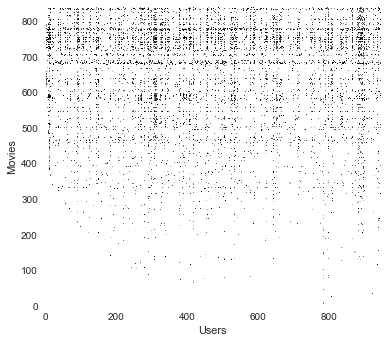

In [2]:
print('Loading movie ratings dataset.')

#  Load data
data = scipy.io.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R'].astype(bool)
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' % np.mean(Y[0, R[0, :]]))

#  We can "visualize" the ratings matrix by plotting it with imagesc

plt.figure()
plt.imshow(Y, aspect='equal', origin='upper', extent=(0, Y.shape[1], 0, Y.shape[0]/2.0))
plt.ylabel('Movies')
plt.xlabel('Users')


In [20]:
def calc_err_factor(X, Theta, Y, R):
    return (np.dot(X, Theta.T) - Y)* R

def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """returns the cost and gradient for the
    """

    # Unfold the U and W matrices from params
    X = np.array(params[:num_movies*num_features]).reshape(num_features, num_movies).T.copy()
    Theta = np.array(params[num_movies*num_features:]).reshape(num_features, num_users).T.copy()


    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the cost function and gradient for collaborative
    #               filtering. Concretely, you should first implement the cost
    #               function (without regularization) and make sure it is
    #               matches our costs. After that, you should implement the
    #               gradient and use the checkCostFunction routine to check
    #               that the gradient is correct. Finally, you should implement
    #               regularization.
    #
    # Notes: X - num_movies  x num_features matrix of movie features
    #        Theta - num_users  x num_features matrix of user features
    #        Y - num_movies x num_users matrix of user ratings of movies
    #        R - num_movies x num_users matrix, where R(i, j) = 1 if the
    #            i-th movie was rated by the j-th user
    #
    # You should set the following variables correctly:
    #
    #        X_grad - num_movies x num_features matrix, containing the
    #                 partial derivatives w.r.t. to each element of X
    #        Theta_grad - num_users x num_features matrix, containing the
    #                     partial derivatives w.r.t. to each element of Theta
    cst = np.power(calc_err_factor(X, Theta, Y, R),2)
    J = np.sum(cst) / 2
    # =============================================================
    lam = Lambda / 2
    X_reg = np.sum(np.power(Theta, 2)) * lam
    Theta_reg = np.sum(np.power(X, 2)) * lam
    
    J = J + X_reg + Theta_reg
    
    X_grad = np.dot(calc_err_factor(X, Theta, Y, R), Theta) + (Lambda * X)
    Theta_grad = np.dot(calc_err_factor(X, Theta, Y, R).T, X) + (Lambda * Theta)
    
    grad = np.hstack((X_grad.T.flatten(),Theta_grad.T.flatten()))

    return J, grad


In [13]:
data = scipy.io.loadmat('ex8_movieParams.mat')
X = data['X']
Theta = data['Theta']
num_users = data['num_users']
num_movies = data['num_movies']
num_features = data['num_features']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

#  Evaluate cost function
J, grad = cofiCostFunc(np.hstack((X.T.flatten(), Theta.T.flatten())), Y, R, num_users, num_movies,
               num_features, 0)

print('Cost at loaded parameters: %f \n(this value should be about 22.22)' % J)

X_reg:  0.0
Theta_reg:  0.0
Cost at loaded parameters: 22.224604 
(this value should be about 22.22)


In [18]:
def computeNumericalGradient(J, theta):
    """computes the numerical gradient of the function J around theta.
    Calling y = J(theta) should return the function value at theta.
    """
# Notes: The following code implements numerical gradient checking, and 
#        returns the numerical gradient.It sets numgrad(i) to (a numerical 
#        approximation of) the partial derivative of J with respect to the 
#        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
#        be the (approximately) the partial derivative of J with respect 
#        to theta(i).)

    numgrad = np.zeros(theta.shape[0])
    perturb = np.zeros(theta.shape[0])
    e = 1e-4
    for p in range(theta.size):

        # Set perturbation vector
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)

        # Compute Numerical Gradient
        numgrad[p] = (loss2[0] - loss1[0]) / (2*e)
        perturb[p] = 0

    return numgrad

def checkCostFunction(Lambda=0):
    """Creates a collaborative filering problem
    to check your cost function and gradients, it will output the
    analytical gradients produced by your code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient
    computations should result in very similar values.
    """

    ## Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = X_t.dot(Theta_t.T)
    Y[np.where(np.random.random_sample(Y.shape) > 0.5, True, False)] = 0
    R = np.zeros(Y.shape)
    R[np.where(Y != 0, True, False)] = 1

    ## Run Gradient Checking
    X = np.random.random_sample(X_t.shape)
    Theta = np.random.random_sample(Theta_t.shape)
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]

   # Unroll parameters
    params = np.hstack((X.T.flatten(), Theta.T.flatten()))

    costFunc = lambda t: cofiCostFunc(t, Y, R, num_users, num_movies, num_features, Lambda)

    def costFunc_w(t):
        Jgrad = costFunc(t)
        return Jgrad

    numgrad = computeNumericalGradient(costFunc_w, params)

    cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)

    print(np.column_stack((numgrad, grad)))

    print('The above two columns you get should be very similar.\n'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)

    print('If your backpropagation implementation is correct, then\n '
          'the relative difference will be small (less than 1e-9). \n'
          '\nRelative Difference: %g\n' % diff)

In [6]:
print('Checking Gradients (without regularization) ...')

#  Check gradients by running checkNNGradients
checkCostFunction()

Checking Gradients (without regularization) ...
[[-0.36246324 -0.36246324]
 [ 0.65838934  0.65838934]
 [ 0.51316419  0.51316419]
 [ 0.12143459  0.12143459]
 [ 0.13603337  0.13603337]
 [ 0.38543046  0.38543046]
 [ 0.49963083  0.49963083]
 [ 0.50910368  0.50910368]
 [-0.00326615 -0.00326615]
 [ 0.64859832  0.64859832]
 [ 0.86336935  0.86336935]
 [ 0.67057235  0.67057235]
 [ 0.13924584  0.13924584]
 [ 0.92922205  0.92922205]
 [ 0.4922952   0.4922952 ]
 [-2.05134927 -2.05134927]
 [ 0.58830452  0.58830452]
 [ 0.04953503  0.04953503]
 [ 0.53634484  0.53634484]
 [ 0.35214442  0.35214442]
 [-1.70204554 -1.70204554]
 [ 0.48175974  0.48175974]
 [ 0.22247626  0.22247626]
 [ 1.47849312  1.47849312]
 [ 1.04672282  1.04672282]
 [-2.06824442 -2.06824442]
 [ 0.53505458  0.53505458]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)


If your backpropagation implementation is correct, then
 the relative difference will be small (less than 1e

In [16]:
#  Evaluate cost function
J, grad = cofiCostFunc(np.hstack((X.T.flatten(), Theta.T.flatten())), Y, R, num_users, num_movies,
               num_features, 1.5)

print('Cost at loaded parameters (lambda = 1.5): %f \n(this value should be about 31.34)\n' % J)


Cost at loaded parameters (lambda = 1.5): 31.344056 
(this value should be about 31.34)



In [21]:
print('Checking Gradients (with regularization) ...')

#  Check gradients by running checkNNGradients
checkCostFunction(1.5)


Checking Gradients (with regularization) ...
[[ 2.10330655  2.10330655]
 [ 0.37389982  0.37389982]
 [ 0.06215942  0.06215942]
 [ 0.58748263  0.58748263]
 [ 2.57738743  2.57738743]
 [ 1.83195966  1.83195966]
 [ 0.18381011  0.18381011]
 [ 1.69298708  1.69298708]
 [ 3.21457466  3.21457466]
 [ 0.08507165  0.08507165]
 [ 1.38088496  1.38088496]
 [ 1.96993766  1.96993766]
 [ 0.84284966  0.84284966]
 [ 1.40465666  1.40465666]
 [ 0.63805272  0.63805272]
 [ 0.9399751   0.9399751 ]
 [ 1.65443877  1.65443877]
 [ 2.06377808  2.06377808]
 [ 0.19748836  0.19748836]
 [ 0.5021456   0.5021456 ]
 [ 0.83992107  0.83992107]
 [ 2.47614745  2.47614745]
 [ 2.69504115  2.69504115]
 [ 1.42287189  1.42287189]
 [ 0.32129569  0.32129569]
 [ 0.11529285  0.11529285]
 [ 2.01816509  2.01816509]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)


If your backpropagation implementation is correct, then
 the relative difference will be small (less than 1e-9)

In [25]:
import io

def loadMovieList():
    """
    reads the fixed movie list in movie.txt
    and returns a cell array of the words in movieList.
    """

    ## Read the fixed movieulary list
    with io.open('movie_ids.txt', encoding='ISO-8859-1') as f:

        # Store all movies in cell array movie{}
        n = 1682  # Total number of movies 

        movieList = []
        for i in range(n):
            # Read line
            line = f.readline()
            # Word Index (can ignore since it will be = i)
            str = line.split()
            # Actual Word
            movieList.append(' '.join(str[1:]).strip())
        return movieList


In [26]:
movieList = loadMovieList()

#  Initialize my ratings
my_ratings = np.zeros(1682)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s\n' % (my_ratings[i], movieList[i]))


New user ratings:
Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forrest Gump (1994)

Rated 2 for Silence of the Lambs, The (1991)

Rated 4 for Alien (1979)

Rated 5 for Die Hard 2 (1990)

Rated 5 for Sphere (1998)



In [28]:
def normalizeRatings(Y, R):
    """normalized Y so that each movie has a rating of 0 on average,
    and returns the mean rating in Ymean.
    """

    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(n):
        idx = (R[i,:]==1).nonzero()[0]
        if len(idx):
            Ymean[i] = np.mean(Y[i, idx])
            Ynorm[i, idx] = Y[i, idx] - Ymean[i]
        else:
            Ymean[i] = 0.0
            Ynorm[i,idx] = 0.0

    return Ynorm, Ymean


In [30]:
from scipy.optimize import minimize

print('\nTraining collaborative filtering...')

#  Load data
data = scipy.io.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R'].astype(bool)

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.column_stack((my_ratings, Y))
R = np.column_stack((my_ratings, R)).astype(bool)

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.rand(num_movies, num_features)
Theta = np.random.rand(num_users, num_features)

initial_parameters = np.hstack((X.T.flatten(), Theta.T.flatten()))
# Set Regularization
Lambda = 10

costFunc = lambda p: cofiCostFunc(p, Ynorm, R, num_users, num_movies, num_features, Lambda)[0]
gradFunc = lambda p: cofiCostFunc(p, Ynorm, R, num_users, num_movies, num_features, Lambda)[1]

result = minimize(costFunc, initial_parameters, method='CG', jac=gradFunc, options={'disp': True, 'maxiter': 1000.0})
theta = result.x
cost = result.fun


# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')


Training collaborative filtering...
Optimization terminated successfully.
         Current function value: 35118.790099
         Iterations: 280
         Function evaluations: 425
         Gradient evaluations: 425
Recommender system learning completed.


In [31]:
p = X.dot(Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = loadMovieList()

# sort predictions descending
pre=np.array([[idx, p] for idx, p in enumerate(my_predictions)])
post = pre[pre[:,1].argsort()[::-1]]
r = post[:,1]
ix = post[:,0]

print('\nTop recommendations for you:')
for i in range(10):
    j = int(ix[i])
    print('Predicting rating %.1f for movie %s\n' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s\n' % (my_ratings[i], movieList[i]))


Top recommendations for you:
Predicting rating 5.6 for movie Lawrence of Arabia (1962)

Predicting rating 5.1 for movie Usual Suspects, The (1995)

Predicting rating 5.0 for movie Graduate, The (1967)

Predicting rating 5.0 for movie Great Day in Harlem, A (1994)

Predicting rating 5.0 for movie Raging Bull (1980)

Predicting rating 4.8 for movie My Own Private Idaho (1991)

Predicting rating 4.7 for movie Third Man, The (1949)

Predicting rating 4.6 for movie When Harry Met Sally... (1989)

Predicting rating 4.6 for movie Big Sleep, The (1946)

Predicting rating 4.6 for movie Braveheart (1995)


Original ratings provided:
Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forrest Gump (1994)

Rated 2 for Silence of the Lambs, The (1991)

Rated 4 for Alien (1979)

Rated 5 for Die Hard 2 (1990)

Rated 5 